# **Exploratory Data Analysis - EDA**

# Clean and Merge Datasets:
- Filtered movies released between 2000 and 2010
- Removed rows with missing or zero revenue
- Extracted global average inflation for each year from the inflation dataset
- Merged average inflation data into the movies dataset based on release year

I also saved cleaned versions of datasets for later use.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency


# Load datasets
movies_df = pd.read_csv('/content/Movies.csv')
inflation_df = pd.read_csv('/content/global_inflation_data.csv')

# Clean movies dataset
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
movies_df = movies_df.dropna(subset=['release_date', 'revenue', 'genres'])
movies_df = movies_df[movies_df['revenue'] > 0]
movies_df['genres'] = movies_df['genres'].astype(str).str.split(',')
movies_df['release_year'] = movies_df['release_date'].dt.year
movies_df = movies_df[(movies_df['release_year'] >= 2000) & (movies_df['release_year'] <= 2010)]

# Clean inflation dataset
inflation_df = inflation_df.loc[:, ['country_name'] + [str(year) for year in range(2000, 2011)]]
inflation_by_year = inflation_df.drop(columns=['country_name']).T
inflation_by_year.index.name = 'year'
inflation_by_year.columns = [f'country_{i}' for i in range(inflation_by_year.shape[1])]
inflation_by_year = inflation_by_year.reset_index()
inflation_by_year['year'] = inflation_by_year['year'].astype(int)
inflation_by_year['mean_inflation'] = inflation_by_year.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').mean(axis=1)

# Merge inflation to movies
inflation_map = inflation_by_year.set_index('year')['mean_inflation'].to_dict()
movies_df['mean_inflation'] = movies_df['release_year'].map(inflation_map)

# Save cleaned data for later steps
movies_df.to_csv('/content/Movies_CLEANED.csv', index=False)
inflation_by_year.to_csv('/content/Inflation_CLEANED.csv', index=False)


# Data Visualization
This section provides visual and statistical exploration of the dataset. I examined trends in movie production, inflation rates, and how inflation may affect revenues and genres.

# • Number of movies released per year
Bar Chart to show how many movies were released each year.

The number of movies produced per year remained relatively stable from 2000 to 2010, with a slight increase around the mid-2000s. This trend could indicate a rise in global film production during the early 2000s, supported by advancing technology and expanding distribution networks.


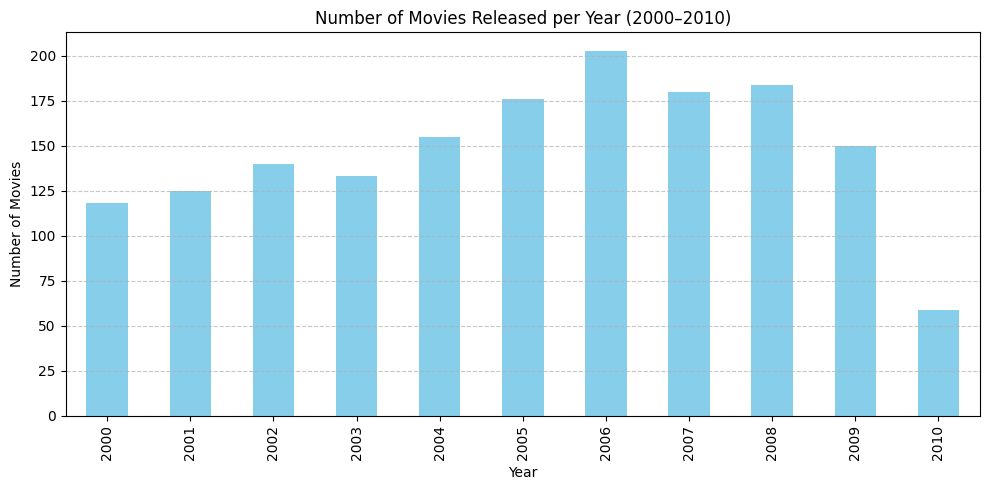

In [13]:

plt.figure(figsize=(10, 5))
movies_df['release_year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Movies Released per Year (2000–2010)')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# • Average global inflation over time
Line plot to track how inflation changed across years.

Inflation remained relatively stable until 2008, when a noticeable spike occurred due to the global financial crisis.
It can be said that this trend provides context for economic challenges that may have affected consumer behavior and movie industry investments.


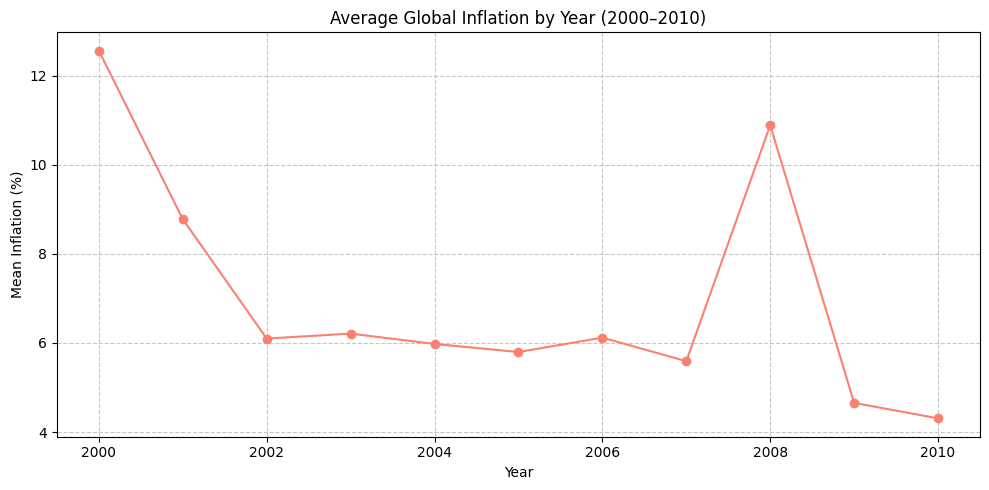

In [14]:

plt.figure(figsize=(10, 5))
plt.plot(inflation_by_year['year'], inflation_by_year['mean_inflation'], marker='o', color='salmon')
plt.title('Average Global Inflation by Year (2000–2010)')
plt.xlabel('Year')
plt.ylabel('Mean Inflation (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# • Boxplot of movie revenues grouped by each year's own inflation
Boxplot to compare revenue variability by year.

Revenue distributions vary widely from year to year. The revenue distribution appears to be wider and more variable in years with mid-to-high inflation. Some years (e.g., 2009) show tighter distributions and lower medians. This helps identify periods of economic stress or creative boom within the film industry.


<ipython-input-15-8e0f29bdf478>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=movies_df, x='release_year', y='revenue', palette='pastel')


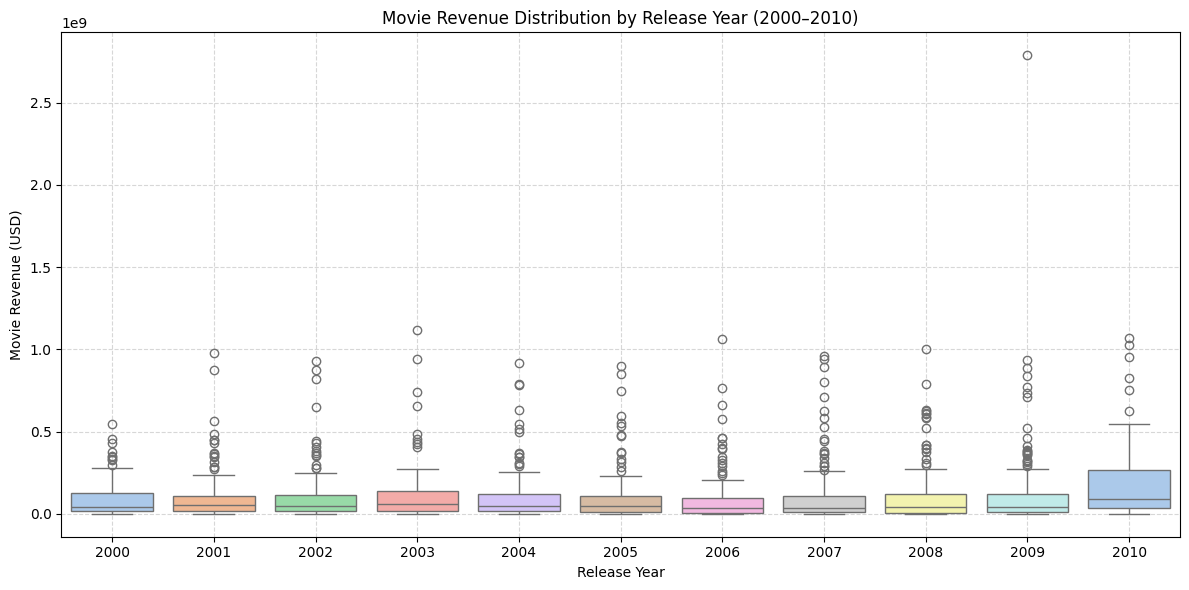

In [15]:

movies_df['mean_inflation_rounded'] = movies_df['mean_inflation'].round()

plt.figure(figsize=(12, 6))
sns.boxplot(data=movies_df, x='release_year', y='revenue', palette='pastel')
plt.title('Movie Revenue Distribution by Release Year (2000–2010)')
plt.xlabel('Release Year')
plt.ylabel('Movie Revenue (USD)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# • Scatter plot of inflation vs movie revenue
Scatter Plot to examine relationship between inflation and revenue with color-coded revenue categories.

The plot reveals that movies with varying revenues exist across all inflation years. There is no consistent clustering, indicating inflation alone does not predict revenue outcomes.

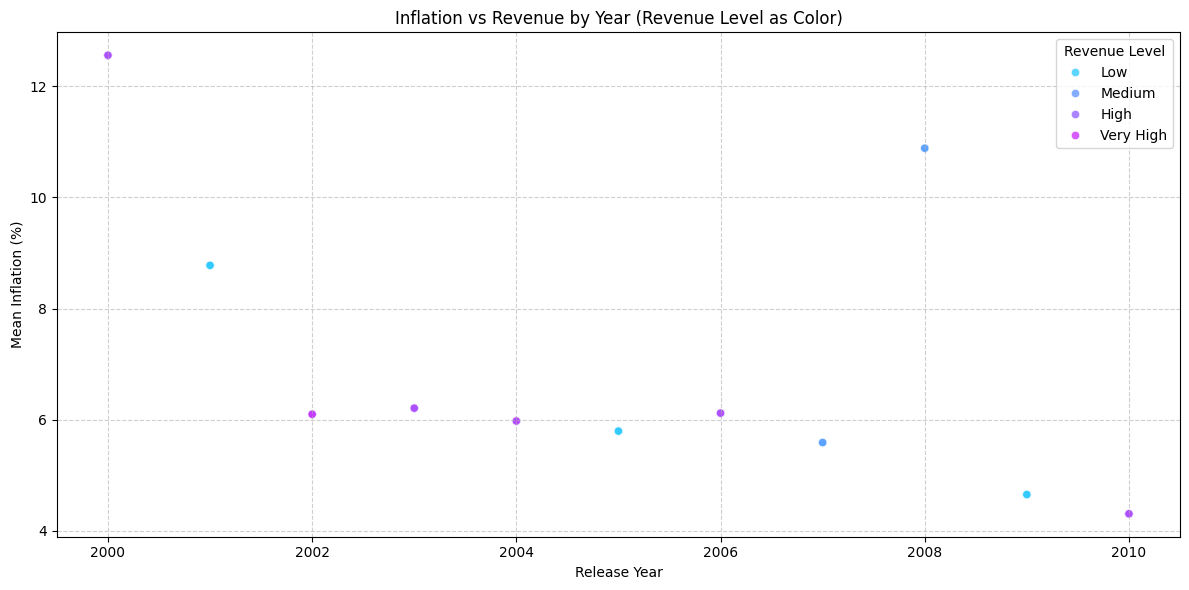

In [16]:
movies_df['Revenue Level'] = pd.qcut(movies_df['revenue'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=movies_df,
    x='release_year',
    y='mean_inflation',
    hue='Revenue Level',
    palette='cool',
    alpha=0.8
)
plt.title('Inflation vs Revenue by Year (Revenue Level as Color)')
plt.xlabel('Release Year')
plt.ylabel('Mean Inflation (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# • Correlation heatmap
Heatmap to quantify linear relationships between numerical variables.

The correlation between inflation and revenue is weak and slightly negative, suggesting possible inverse influence. This supports visual interpretations made in earlier scatter plots.

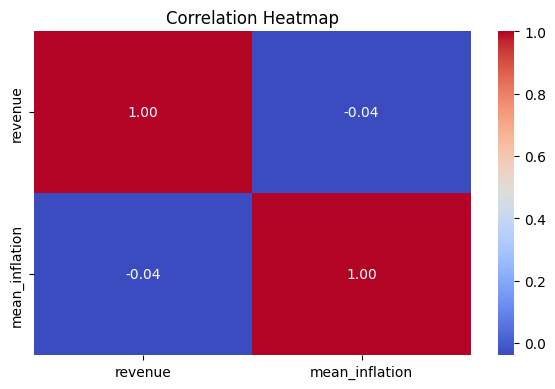

In [17]:

corr_df = movies_df[['revenue', 'mean_inflation']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


# • Average revenue per genre
Boxplot to compare revenue variation across most common genres.
Action and Adventure genres tend to have higher medians, possibly due to their global appeal and production scale. Other genres like Horror and Romance are more variable in revenue.

<ipython-input-18-f489754e8031>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_genres, x='genres', y='revenue', palette='Set3')


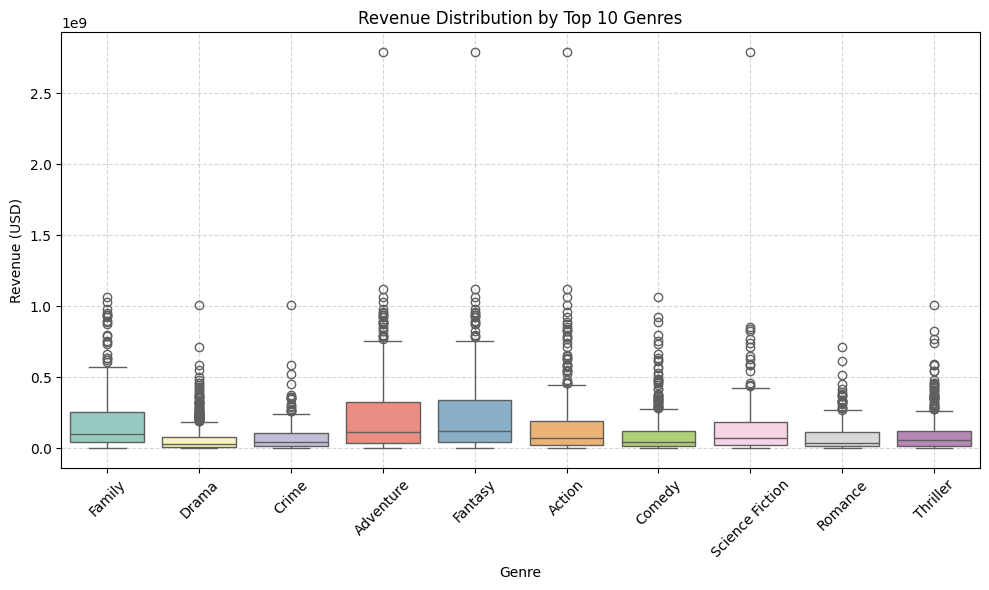

In [18]:
movies_exploded = movies_df.explode('genres')
movies_exploded['genres'] = movies_exploded['genres'].str.strip()
top_genres = movies_exploded['genres'].value_counts().head(10).index.tolist()
filtered_genres = movies_exploded[movies_exploded['genres'].isin(top_genres)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_genres, x='genres', y='revenue', palette='Set3')
plt.title('Revenue Distribution by Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# • Summary statistics


Revenue data exhibits a high standard deviation, confirming wide dispersion, indicating skewness. Inflation is far more stable and compact, as previously suggested by line plots and distribution assessments.


In [19]:
summary_stats = movies_df[['revenue', 'mean_inflation']].describe()
print("\nSummary Statistics:\n", summary_stats)


Summary Statistics:
             revenue  mean_inflation
count  1.623000e+03     1623.000000
mean   1.051536e+08        7.029148
std    1.745519e+08        2.380859
min    1.000000e+00        4.308187
25%    1.199601e+07        5.795699
50%    4.546530e+07        6.098571
75%    1.197236e+08        8.777005
max    2.787965e+09       12.556284


# • Conclusion

This exploratory data analysis explored the relationship between global inflation and movie industry trends from 2000 to 2010 using data from TMDB and global inflation statistics.
Overall, while inflation may contribute to shifts in audience spending and production decisions, it does not appear to be a dominant factor in determining movie revenue performance. Other factors must be explored.